In [60]:
import os
import cv2
import torch
import gdown
import numpy as np
import matplotlib.pyplot as plt
from RealESRGAN import RealESRGAN
from cv2.ximgproc import guidedFilter
from blurgenerator import lens_blur_with_depth_map
from transformers import DPTImageProcessor, DPTForDepthEstimation, AutoImageProcessor, AutoModelForDepthEstimation

In [73]:
#DEVIDE AGNOSTIC CODE
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else: 
    device = torch.device("cpu")

print('device:', device)

device: cpu


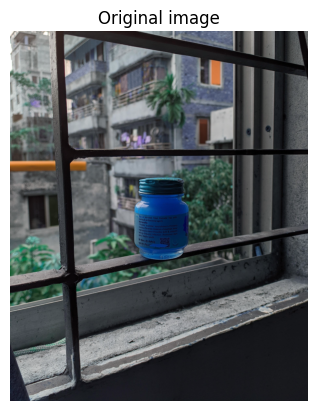

In [74]:
path = "test_images/PXL_20240609_083107374.jpg"

image = cv2.imread(path)
image_data = np.copy(image)

plt.imshow(image_data)
plt.title('Original image')
plt.axis('off')  # Hide the axis
plt.show()

In [75]:
def create_model_directory(base_path):
    # Create the full path for the new directory
    model_path = os.path.join(base_path, "model")
    
    # Check if the directory already exists
    if not os.path.exists(model_path):
        # Create the directory
        os.makedirs(model_path)
        print(f"Directory 'model' created at: {model_path}")
        processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
        model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf")
        processor.save_pretrained(model_path)
        model.save_pretrained(model_path)

    else:
        print(f"Directory 'model' already exists at: {model_path}")

    return model_path

root_path = os.getcwd()
model_path = create_model_directory(root_path)
print(f"New directory path: {model_path}")

Directory 'model' already exists at: /Users/hasibulhasan/pytorch/github/depth_blur/model
New directory path: /Users/hasibulhasan/pytorch/github/depth_blur/model


In [76]:

url = "https://drive.google.com/drive/folders/12mN30g2wdvffbaWgOwu6BZcDGeBfe82e?usp=drive_link"
weights_path = os.path.join(root_path, "weights")
if url.split('/')[-1] == '?usp=sharing':
    url= url.replace('?usp=sharing','')
if not os.path.exists(weights_path):
    print("Downloading......")
    gdown.download_folder(url)
else: 
    print("File already exists..")


File already exists..


Successfully loaded DPT model
Successfully preprocessed image for DPT model
Inference done for DPT Model


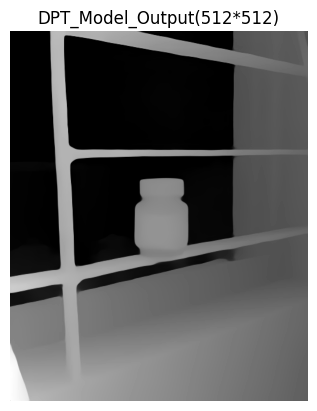

True

In [77]:

processor = AutoImageProcessor.from_pretrained(model_path)
model = AutoModelForDepthEstimation.from_pretrained(model_path)
model.to(device)
print("Successfully loaded DPT model")
#PRE-PRECESS IMAGE
inputs = processor(images=image, return_tensors="pt").to(device)
print("Successfully preprocessed image for DPT model")
#FEED INPUT INTO DPT MODEL
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth
print("Inference done for DPT Model")
#POSTPROCESS AND SHOW ORIGINAL DEPTH OUTPUT
output = predicted_depth.cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth_og_np = np.squeeze(formatted, axis=0)
plt.imshow(depth_og_np, cmap='gray')
plt.title('DPT_Model_Output(512*512)')
plt.axis('off')  # Hide the axis
plt.show()
cv2.imwrite("output/depth_og_np.jpg",depth_og_np)


In [78]:
#DEVIDE AGNOSTIC CODE
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")

print('device:', device)

(644, 518)


Successfully preprocessed output for RealESRGAN Model
Successfully loaded RealESRGAN model
Inference done for RealESRGAN Model


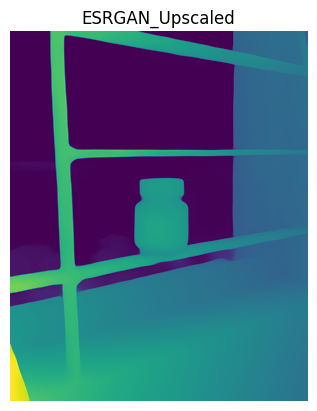

In [79]:
#CREATE FAKE RGB(Stacked_Depth) FROM B&H DEPTH FOR RealESRGAN MODEL
depth_fake_rgb = np.stack((depth_og_np,)*3, axis=-1)
print("Successfully preprocessed output for RealESRGAN Model")

#LOAD RealESRGAN MODEL
model_scale = "4" #@param ["2", "4", "8"] {allow-input: false}
model = RealESRGAN(device, scale=int(model_scale))
model.load_weights(f'weights/RealESRGAN_x{model_scale}plus.pth')
print("Successfully loaded RealESRGAN model")
#PREDICT RealESRGAN
hr_image = model.predict(depth_fake_rgb)
print("Inference done for RealESRGAN Model")

# Convert the PIL image to a NumPy array
hr_image_np = np.array(hr_image)[..., 0]

plt.imshow(hr_image_np)
plt.title('ESRGAN_Upscaled')
plt.axis('off')  # Hide the axis
plt.show()


899 1150 899 1150


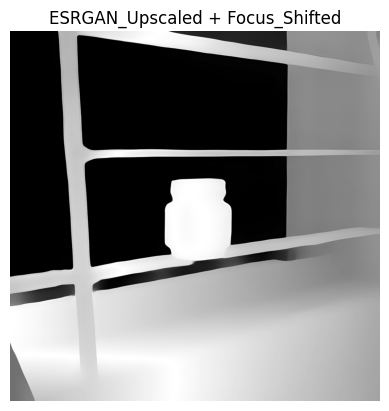

In [51]:
def adjust_depth_map_with_focus(depth_map, focus_point, blur_factor):
    region_size = blur_factor  # This gives a 3x3 region
    half_region = region_size // 2

    # Define Focus Region Pointer
    x_start = int(max(focus_point[0] - half_region, 0))
    x_end = int(min(focus_point[0] + half_region + 1, depth_map.shape[1]))
    y_start = int(max(focus_point[1] - half_region, 0))
    y_end = int(min(focus_point[1] + half_region + 1, depth_map.shape[0]))

    print(x_start,x_end,y_start,y_end)

    focus_region = depth_map[y_start:y_end, x_start:x_end]

    # Calculate average of that Focus Region
    focus_depth = np.mean(focus_region)

    # That fucking euclidian distance
    dist_map = (np.sqrt( (depth_map - focus_depth)**2))

    dist_map_normalized = (dist_map - np.min(dist_map)) / (np.max(dist_map) - np.min(dist_map))

    dist_map_normalized_inverted = 1 - dist_map_normalized

    return dist_map_normalized_inverted


focus_point = (hr_image_np.shape[1] // 2, hr_image_np.shape[0] // 2)  # Example: focus at the center
blur_factor = 250.0
adjusted_depth_map_inverted = adjust_depth_map_with_focus(hr_image_np, focus_point, blur_factor)

plt.imshow(adjusted_depth_map_inverted, cmap='gray')
plt.title('ESRGAN_Upscaled + Focus_Shifted')
plt.axis('off')  # Hide the axis
plt.show()


Successfully resized Original image to 4k
Successfully resized RealESRGAN output image to 4k


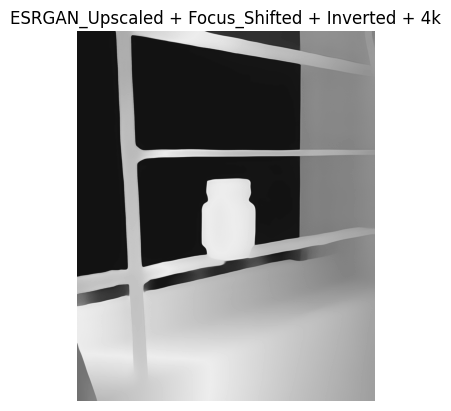

True

In [52]:
def resize_to_4k(img):
    height = img.shape[0]
    width = img.shape[1]
    my_height = 0
    my_width = 0
    if height > width:
        my_height = 4000
        my_width = int(my_height/(height/width))
    else:
        my_width = 4000
        my_height = int(my_width/(width/height))
    return cv2.resize(img, (my_width, my_height), interpolation=cv2.INTER_CUBIC)

image_cv_4k = resize_to_4k(image)
print("Successfully resized Original image to 4k")

adjusted_depth_map_inverted_4k = cv2.resize(adjusted_depth_map_inverted, (image_cv_4k.shape[1], image_cv_4k.shape[0]), interpolation=cv2.INTER_CUBIC).astype(np.float32)
print("Successfully resized RealESRGAN output image to 4k")

plt.imshow(adjusted_depth_map_inverted_4k, cmap='gray')
plt.title('ESRGAN_Upscaled + Focus_Shifted + Inverted + 4k')
plt.axis('off')  # Hide the axis
plt.show()
cv2.imwrite("output/adjusted_depth_map_inverted_4k.jpg",adjusted_depth_map_inverted_4k)



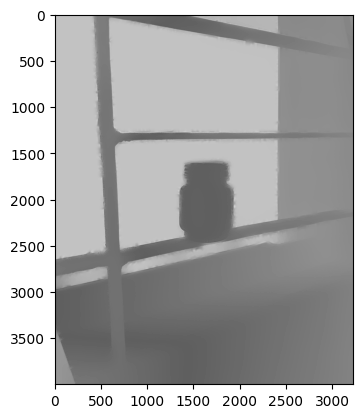

True

In [53]:

def laplacian_of_gaussian_edge_detection(image, ksize=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (ksize, ksize), 0)
    edges = cv2.Laplacian(blur, cv2.CV_16S, ksize=ksize)
    abs_edges = cv2.convertScaleAbs(edges)
    return abs_edges

def apply_guided_filter(image, depth_map, radius=12, eps=0.9, iterations=90):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    guided_depth = depth_map
    for i in range(iterations):
        guided_depth = guidedFilter(guide=gray_image, src=guided_depth, radius=radius, eps=eps)
    return guided_depth

edges = laplacian_of_gaussian_edge_detection(image_cv_4k, ksize=7)
_, binary_edges = cv2.threshold(edges, 50, 150, cv2.THRESH_BINARY)
edge_mask = binary_edges > 0
refined_depth = np.where(edge_mask, adjusted_depth_map_inverted_4k, adjusted_depth_map_inverted_4k)

adjusted_depth_map_inverted_4k_refined = apply_guided_filter(image_cv_4k, refined_depth, radius=8, eps=0.1, iterations=12)
adjusted_depth_map_inverted_4k_refined = cv2.normalize(adjusted_depth_map_inverted_4k_refined, None, 0, 1, cv2.NORM_MINMAX)
adjusted_depth_map_4k_refined = np.max(adjusted_depth_map_inverted_4k_refined) - adjusted_depth_map_inverted_4k_refined
adjusted_depth_map_4k_refined = cv2.normalize(adjusted_depth_map_4k_refined, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(adjusted_depth_map_4k_refined, cmap = "gray")
plt.show()
cv2.imwrite("output/adjusted_depth_map_4k_refined.jpg",adjusted_depth_map_4k_refined)


In [54]:
print(np.min(adjusted_depth_map_4k_refined),np.max(adjusted_depth_map_4k_refined))

0.0 255.0


In [55]:
# result = lens_blur_with_depth_map(
#    image_cv_4k,
#    depth_map=np.stack([adjusted_depth_map_4k_refined] * 3, axis=-1).astype(np.uint8),
#    components=5,
#    exposure_gamma=5,
#    num_layers=2,
#    min_blur=1,
#    max_blur=60
# )
# image = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
# plt.imshow(image)
# plt.show()
# cv2.imwrite("output/final_output.jpg",result)

In [56]:
print(np.min(adjusted_depth_map_inverted_4k),np.max(adjusted_depth_map_inverted_4k))
adjusted_depth_map_inverted_4k = cv2.normalize(adjusted_depth_map_inverted_4k, None, 0, 255, cv2.NORM_MINMAX)
adjusted_depth_map_4k = np.max(adjusted_depth_map_inverted_4k) - adjusted_depth_map_inverted_4k

print(np.min(adjusted_depth_map_4k),np.max(adjusted_depth_map_4k))
adjusted_depth_map_4k = cv2.normalize(adjusted_depth_map_4k, None, 0, 255, cv2.NORM_MINMAX)
print(np.min(adjusted_depth_map_4k),np.max(adjusted_depth_map_4k))


-0.08670244 1.0845708
0.0 255.00002
0.0 255.0


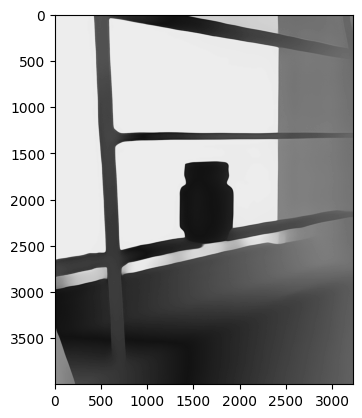

In [57]:
plt.imshow(adjusted_depth_map_4k, cmap = "gray")
plt.show()

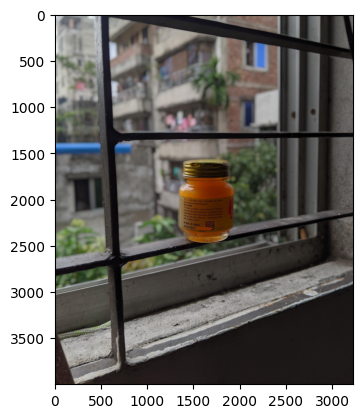

True

In [58]:
result = lens_blur_with_depth_map(
   image_cv_4k,
   depth_map=np.stack([adjusted_depth_map_4k] * 3, axis=-1).astype(np.uint8),
   components=5,
   exposure_gamma=5,
   num_layers=10,
   min_blur=1,
   max_blur=25
)
image = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cv2.imwrite("output/final_output.jpg",result)

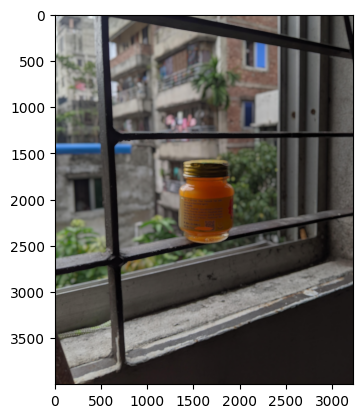

True

In [59]:
result = lens_blur_with_depth_map(
   image_cv_4k,
   depth_map=np.stack([adjusted_depth_map_4k_refined] * 3, axis=-1).astype(np.uint8),
   components=5,
   exposure_gamma=5,
   num_layers=10,
   min_blur=1,
   max_blur=25
)
image = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cv2.imwrite("output/final_output.jpg",result)